## Cincinnati Logistic and Poisson Regression (Proof of Concept)
##### Code by Drew Gobbi 12/3/2019

### Import Packages and Data Cleaning 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads
import pickle

In [2]:
pkl_in_Cin = open('countMedicalFacilitiesWithin2milesCinbyTract.pkl', 'rb')

fac = pickle.load(pkl_in_Cin)

In [3]:
fac.head()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi,geometry
0,52.00,3,1,7,6,0,1,2,1,1,9,9,2,0,0,13,1,16,"POLYGON ((-84.43168 39.15720, -84.43177 39.156..."
1,53.01,2,1,7,6,0,1,2,1,1,9,7,2,0,0,15,0,13,"POLYGON ((-84.42516 39.15576, -84.42513 39.155..."
2,53.02,1,1,4,5,0,1,3,1,1,7,8,1,0,0,12,0,12,"POLYGON ((-84.40766 39.15576, -84.40748 39.155..."
3,54.00,2,1,7,6,0,1,2,1,1,9,6,2,0,0,15,0,12,"POLYGON ((-84.42096 39.16456, -84.41972 39.163..."
4,55.00,1,1,2,4,0,1,3,0,1,6,10,1,0,0,11,0,11,"MULTIPOLYGON (((-84.39309 39.16722, -84.39303 ..."


In [4]:
fac.dtypes

CensusTract                        object
HospitalsGeneralCount2mi            int64
HospitalsPsychCount2mi              int64
SurgicalCentersCount2mi             int64
UrgentCareCount2mi                  int64
WomensClinicsCount2mi               int64
PainManagementCount2mi              int64
PhysicalTherapyCount2mi             int64
MentalFacilitiesCount2mi            int64
SubstanceAbuseCount2mi              int64
OtherMedicalFacilitesCount2mi       int64
NursingAssistedLiveCount2mi         int64
HospiceCount2mi                     int64
HospitalsChildCount2mi              int64
ChildFacilitiesCount2mi             int64
PharmCount2mi                       int64
DrugDropCount2mi                    int64
NaloxoneDistribCount2mi             int64
geometry                         geometry
dtype: object

In [5]:
pdb = pd.read_csv('pdb2019trv3_us.csv')

In [6]:
cin = pdb[(pdb['State_name'] == 'Ohio') & (pdb['County_name'] == 'Hamilton County')]

In [7]:
var = ['Med_HHD_Inc_ACS_13_17', 'pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17',
      'pct_Pop_25_44_ACS_13_17', 'Tract']

In [8]:
cin = cin.filter(var)

In [9]:
#align labeling of tracts between fac and pdb - need codes w/o decimals
fac.CensusTract = fac.CensusTract.astype(float)
fac.CensusTract = fac.CensusTract *100

In [10]:
df = fac.merge(cin, left_on='CensusTract', right_on='Tract')

In [11]:
df.head()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,...,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi,geometry,Med_HHD_Inc_ACS_13_17,pct_College_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,Tract
0,5200.0,3,1,7,6,0,1,2,1,1,...,13,1,16,"POLYGON ((-84.43168 39.15720, -84.43177 39.156...","$69,318",68.86,53.27,11.99,50.83,5200
1,5301.0,2,1,7,6,0,1,2,1,1,...,15,0,13,"POLYGON ((-84.42516 39.15576, -84.42513 39.155...","$56,563",58.51,45.00,10.18,44.91,5301
2,5302.0,1,1,4,5,0,1,3,1,1,...,12,0,12,"POLYGON ((-84.40766 39.15576, -84.40748 39.155...","$66,250",65.38,47.86,12.31,35.86,5302
3,5400.0,2,1,7,6,0,1,2,1,1,...,15,0,12,"POLYGON ((-84.42096 39.16456, -84.41972 39.163...","$58,654",62.23,44.00,18.04,50.17,5400
4,5500.0,1,1,2,4,0,1,3,0,1,...,11,0,11,"MULTIPOLYGON (((-84.39309 39.16722, -84.39303 ...","$37,052",37.53,42.49,8.67,33.63,5500


In [12]:
df.shape

(126, 25)

In [13]:
df.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry',
       'Med_HHD_Inc_ACS_13_17', 'pct_College_ACS_13_17', 'pct_Males_ACS_13_17',
       'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17', 'Tract'],
      dtype='object')

In [14]:
fac.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry'],
      dtype='object')

### Get EMS Data

In [15]:
from sodapy import Socrata
client = Socrata("data.cincinnati-oh.gov", None)
results = client.get("3gx7-se9a", limit=11000)

# Convert to pandas DataFrame
ems = pd.DataFrame.from_records(results)

In [16]:
ems.to_csv('cincy_ems.csv')

In [17]:
ems.head()

,address_x,agency,arrival_time_primary_unit,beat,closed_time_incident,community_council_neighborhood,create_time_incident,dispatch_time_primary_unit,disposition_text,district,event_number,incident_type_desc,incident_type_id,latitude_x,longitude_x,priority,priority_color
0,16XX CALIFORNIA AV,CPD,NaN,P451,2017-05-16T20:40:39.000,BOND HILL,2017-05-16T20:35:05.000,NaN,BC: BROADCAST,4,CPD170516001810,NaN,DRUG,39.1754784436823,-84.4670395218747,3,NaN
1,16XX ILIFF AV,CPD,2017-10-13T21:58:24.000,P321,2017-10-13T22:16:51.000,WEST PRICE HILL,2017-10-13T21:25:58.000,2017-10-13T21:44:59.000,INV: INV,3,CPD171013002052,DRUG ACTIVITY,DRUG,39.1177910001195,-84.580431,7,YELLOW
2,21XX CLARA ST,CPD,2017-03-22T21:04:18.000,P341,2017-03-23T02:13:01.000,SOUTH FAIRMOUNT,2017-03-22T20:41:51.000,2017-03-22T20:52:13.000,AST: ASSIST,3,CPD170322001510,NaN,HEROINP-COMBINED,39.1227367321796,-84.5518912925694,2,NaN
3,13XX VINE ST,CPD,2017-12-13T02:31:36.000,P121,2017-12-13T02:44:10.000,OTR,2017-12-13T02:29:05.000,2017-12-13T02:30:06.000,INV: INV,1,CPD171213000116,DRUG ACTIVITY,DRUG,39.1095160001195,-84.515049,7,YELLOW
4,2XX W MCMICKEN AV,CPD,NaN,P121,2017-09-05T16:28:05.000,OTR,2017-09-05T16:28:05.000,NaN,ADV:ADVISED,1,CPD170905001184,DRUG COMPLAINT REFERRAL,DRUGR,39.1194960001195,-84.524441,35,PURPLE


In [18]:
ems.longitude_x = ems.longitude_x.astype(float)
ems.latitude_x = ems.latitude_x.astype(float)

In [19]:
ems_gdf = gpd.GeoDataFrame(
    ems, geometry=gpd.points_from_xy(ems.longitude_x, ems.latitude_x))

In [20]:
cin_gdf = gpd.GeoDataFrame(df, geometry=df.geometry)

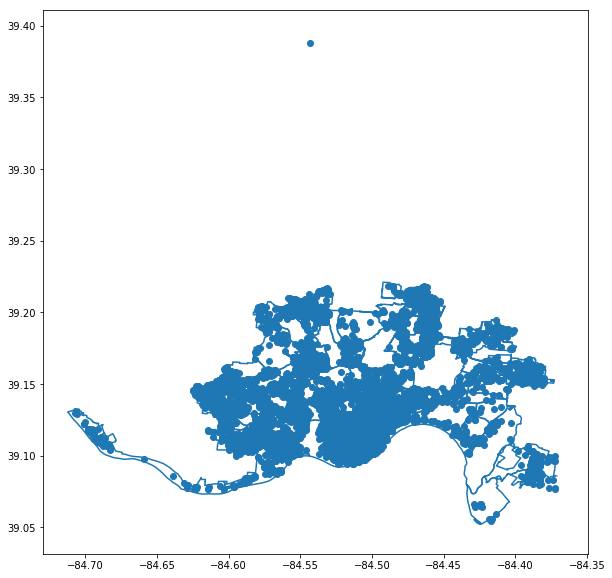

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ems_gdf.plot(ax=ax)
cin_gdf.boundary.plot(ax=ax)

In [22]:
out = pd.DataFrame()
for i in range(len(cin_gdf)):
    temp = ems_gdf[ems_gdf.within(cin_gdf.loc[i,'geometry'])]
    temp['tract'] = cin_gdf.loc[i,'Tract']
    out = pd.concat([out, temp])

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
len(out)

10213

In [24]:
len(ems)

10498

In [25]:
out.closed_time_incident = pd.to_datetime(out.closed_time_incident)

In [26]:
out['year_month'] = out.closed_time_incident.dt.year.astype(float) + out.closed_time_incident.dt.month.astype(float)/100

In [27]:
out.head()

,address_x,agency,arrival_time_primary_unit,beat,closed_time_incident,community_council_neighborhood,create_time_incident,dispatch_time_primary_unit,disposition_text,district,event_number,incident_type_desc,incident_type_id,latitude_x,longitude_x,priority,priority_color,geometry,tract,year_month
89,27XX MADISON RD,CPD,2017-06-07T13:35:34.000,P222,2017-06-07 13:52:13,HYDE PARK - OAKLEY,2017-06-07T13:22:45.000,2017-06-07T13:29:19.000,INV: INV,2,CPD170607000895,DRUG ACTIVITY,DRUG,39.145535,-84.440570,7,YELLOW,POINT (-84.44057 39.14553),5200,2017.06
1022,MADISON RD / EDWARDS RD,CPD,2017-06-07T00:58:58.000,P222,2017-06-07 01:23:36,HYDE PARK - OAKLEY,2017-06-07T00:44:41.000,2017-06-07T00:58:57.000,SOW: SENT ON WAY,2,CPD170607000050,DRUG ACTIVITY,DRUG,39.145584,-84.441808,7,YELLOW,POINT (-84.44181 39.14558),5200,2017.06
1865,38XX MILLSBRAE AV,CPD,NaN,P222,2017-06-21 20:34:49,OAKLEY,2017-06-21T20:34:49.000,NaN,ADV:ADVISED,2,CPD170621001651,DRUG COMPLAINT REFERRAL,DRUGR,39.149455,-84.440186,35,PURPLE,POINT (-84.44019 39.14946),5200,2017.06
3017,ATLANTIC AV / MILLSBRAE AV,CPD,NaN,P222,2017-10-23 22:18:45,OAKLEY,2017-10-23T22:18:45.000,NaN,ADV:ADVISED,2,CPD171023001616,DRUG COMPLAINT REFERRAL,DRUGR,39.148527,-84.439880,35,PURPLE,POINT (-84.43988 39.14853),5200,2017.10
3714,27XX MADISON RD,CPD,2017-04-05T09:40:12.000,P222,2017-04-05 11:51:58,OAKLEY,2017-04-05T09:36:30.000,2017-04-05T09:38:21.000,ARR: ARREST,2,CPD170405000402,NaN,HEROINP-COMBINED,39.146658,-84.441568,2,NaN,POINT (-84.44157 39.14666),5200,2017.04


In [28]:
mt = out.groupby([out['year_month'],  out['tract']]).agg({'count'})

In [29]:
mt = mt['event_number']
mt.reset_index(inplace=True)

mt.rename(columns={'count': 'ems_call'}, inplace=True)

In [30]:
mt.head()

,year_month,tract,ems_call
0,2017.01,200,4
1,2017.01,700,28
2,2017.01,900,20
3,2017.01,1000,3
4,2017.01,1100,1


In [31]:
cin_gdf.shape

(126, 25)

In [32]:
cin_gdf = cin_gdf.merge(mt, left_on='Tract', right_on='tract')

In [33]:
cin_gdf.shape

(1238, 28)

In [34]:
cin_gdf.drop_duplicates(inplace=True)

### Poisson Regression 

In [35]:
cin_gdf.head()

,CensusTract,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,...,geometry,Med_HHD_Inc_ACS_13_17,pct_College_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,Tract,year_month,tract,ems_call
0,5200.0,3,1,7,6,0,1,2,1,1,...,"POLYGON ((-84.43168 39.15720, -84.43177 39.156...","$69,318",68.86,53.27,11.99,50.83,5200,2017.01,5200,1
1,5200.0,3,1,7,6,0,1,2,1,1,...,"POLYGON ((-84.43168 39.15720, -84.43177 39.156...","$69,318",68.86,53.27,11.99,50.83,5200,2017.02,5200,1
2,5200.0,3,1,7,6,0,1,2,1,1,...,"POLYGON ((-84.43168 39.15720, -84.43177 39.156...","$69,318",68.86,53.27,11.99,50.83,5200,2017.04,5200,2
3,5200.0,3,1,7,6,0,1,2,1,1,...,"POLYGON ((-84.43168 39.15720, -84.43177 39.156...","$69,318",68.86,53.27,11.99,50.83,5200,2017.05,5200,2
4,5200.0,3,1,7,6,0,1,2,1,1,...,"POLYGON ((-84.43168 39.15720, -84.43177 39.156...","$69,318",68.86,53.27,11.99,50.83,5200,2017.06,5200,6


In [36]:
cin_gdf.dtypes

CensusTract                       float64
HospitalsGeneralCount2mi            int64
HospitalsPsychCount2mi              int64
SurgicalCentersCount2mi             int64
UrgentCareCount2mi                  int64
WomensClinicsCount2mi               int64
PainManagementCount2mi              int64
PhysicalTherapyCount2mi             int64
MentalFacilitiesCount2mi            int64
SubstanceAbuseCount2mi              int64
OtherMedicalFacilitesCount2mi       int64
NursingAssistedLiveCount2mi         int64
HospiceCount2mi                     int64
HospitalsChildCount2mi              int64
ChildFacilitiesCount2mi             int64
PharmCount2mi                       int64
DrugDropCount2mi                    int64
NaloxoneDistribCount2mi             int64
geometry                         geometry
Med_HHD_Inc_ACS_13_17              object
pct_College_ACS_13_17             float64
pct_Males_ACS_13_17               float64
pct_Pop_18_24_ACS_13_17           float64
pct_Pop_25_44_ACS_13_17           

In [37]:
cin_gdf['Med_HHD_Inc_ACS_13_17'] = [x.strip('$') for x in cin_gdf['Med_HHD_Inc_ACS_13_17']]

In [38]:
for i in range(len(cin_gdf['Med_HHD_Inc_ACS_13_17'])):
    cin_gdf['Med_HHD_Inc_ACS_13_17'] = cin_gdf['Med_HHD_Inc_ACS_13_17'][i][:6]

In [39]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][:2]

'69'

In [40]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][3:]

'318'

In [41]:
cin_gdf['Med_HHD_Inc_ACS_13_17'][1][:]

'69,318'

In [42]:
cin_gdf['mhi'] = 0
for i in range(len(cin_gdf)):
    cin_gdf['mhi'][i] = cin_gdf['Med_HHD_Inc_ACS_13_17'][i][:2] + cin_gdf['Med_HHD_Inc_ACS_13_17'][i][3:]

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
cin_gdf['mhi'] = cin_gdf['mhi'].astype(float)

In [44]:
#drop columns redundant for regression 
cin_gdf.drop(['CensusTract', 'geometry', 'tract', 'Med_HHD_Inc_ACS_13_17'], axis=1, inplace=True)

In [45]:
#get fixed effects 
cin_gdf = pd.get_dummies(cin_gdf, columns=['year_month', 'Tract'], drop_first=True)

In [46]:
#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
mask = np.random.rand(len(cin_gdf)) < 0.8
cin_train = cin_gdf[mask]
cin_test = cin_gdf[~mask]
print('Training data set length='+str(len(cin_train)))
print('Testing data set length='+str(len(cin_test)))

Training data set length=980
Testing data set length=258


In [47]:
cin_gdf.head()

,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,...,Tract_26400,Tract_26500,Tract_26600,Tract_26700,Tract_26800,Tract_26900,Tract_27000,Tract_27100,Tract_27200,Tract_27400
0,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
1,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
2,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
3,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
4,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0


In [48]:
y_train, X_train = cin_train.ems_call, cin_train
X_train.drop(columns='ems_call', inplace=True)

y_test, X_test = cin_test.ems_call, cin_test
X_test.drop(columns='ems_call', inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [113]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                  980
Model:                            GLM   Df Residuals:                      856
Model Family:                 Poisson   Df Model:                          123
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2372.8
Date:                Wed, 11 Dec 2019   Deviance:                       1219.7
Time:                        00:30:22   Pearson chi2:                 1.24e+03
No. Iterations:                     6   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
HospitalsGeneralCount2mi          0.2207      0.029      7.688      0.000       0.164       0.277
HospitalsPsychCount2mi            0.1164      0.070      1.665      0.096      -0.021       0.253
SurgicalCentersCount2mi           0.2240      0.024      9.523      0.000       0.178       0.270
UrgentCareCount2mi               -0.5688      0.045    -12.721      0.000      -0.656      -0.481
WomensClinicsCount2mi            -0.2047      0.044     -4.612      0.000      -0.292      -0.118
PainManagementCount2mi            0.5641      0.057      9.886      0.000       0.452       0.676
PhysicalTherapyCount2mi          -0.2230      0.055     -4.071      0.000      -0.330      -0.116
MentalFacilitiesCount2mi         -0.0899      0.035     -2.537      0.011      -0.159      -0.020
SubstanceAbuseCount2mi           -0.0028      0.033     -0.083      0.933      -0.068       0.063
OtherMedicalFacilitesCount2mi     0.0104      0.008      1.233      0.218      -0.006       0.027
NursingAssistedLiveCount2mi       0.0522      0.013      3.920      0.000       0.026       0.078
HospiceCount2mi                  -0.2543      0.064     -3.976      0.000      -0.380      -0.129
HospitalsChildCount2mi           -0.2127      0.026     -8.140      0.000      -0.264      -0.161
ChildFacilitiesCount2mi          -0.3938      0.087     -4.524      0.000      -0.564      -0.223
PharmCount2mi                     0.0552      0.009      6.305      0.000       0.038       0.072
DrugDropCount2mi                 -0.2020      0.040     -5.063      0.000      -0.280      -0.124
NaloxoneDistribCount2mi           0.0137      0.007      1.968      0.049    5.45e-05       0.027
pct_College_ACS_13_17            -0.0064      0.002     -2.663      0.008      -0.011      -0.002
pct_Males_ACS_13_17               0.0121      0.004      3.106      0.002       0.004       0.020
pct_Pop_18_24_ACS_13_17          -0.0064      0.003     -2.502      0.012      -0.011      -0.001
pct_Pop_25_44_ACS_13_17           0.0160      0.006      2.797      0.005       0.005       0.027
mhi                            4.222e-06   3.11e-06      1.358      0.175   -1.87e-06    1.03e-05
year_month_2017.02                0.3131      0.062      5.049      0.000       0.192       0.435
year_month_2017.03                0.5485      0.059      9.245      0.000       0.432       0.665
year_month_2017.04                0.6071      0.059     10.284      0.000       0.491       0.723
year_month_2017.05                0.5583      0.059      9.441      0.000       0.442       0.674
year_month_2017.06                0.5831      0.059      9.832      0.000       0.467       0.699
year_month_2017.07                0.4338      0.062      7.044      0.000       0.313       0.555
year_month_2017.08                0.4093      0.062      6.571      0.000       0.287       0.531
year_month_2017.09        

In [114]:
np.exp(res.params)

HospitalsGeneralCount2mi         1.246889
HospitalsPsychCount2mi           1.123396
SurgicalCentersCount2mi          1.251057
UrgentCareCount2mi               0.566193
WomensClinicsCount2mi            0.814890
PainManagementCount2mi           1.757910
PhysicalTherapyCount2mi          0.800127
MentalFacilitiesCount2mi         0.913979
SubstanceAbuseCount2mi           0.997216
OtherMedicalFacilitesCount2mi    1.010436
NursingAssistedLiveCount2mi      1.053553
HospiceCount2mi                  0.775481
HospitalsChildCount2mi           0.808399
ChildFacilitiesCount2mi          0.674455
PharmCount2mi                    1.056701
DrugDropCount2mi                 0.817095
NaloxoneDistribCount2mi          1.013844
pct_College_ACS_13_17            0.993612
pct_Males_ACS_13_17              1.012144
pct_Pop_18_24_ACS_13_17          0.993605
pct_Pop_25_44_ACS_13_17          1.016176
mhi                              1.000004
year_month_2017.02               1.367632
year_month_2017.03               1

In [50]:
poisson_predictions = res.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
1,2.439206,0.568852,1.544323,3.852646
24,3.338747,0.696016,2.218895,5.023776
27,2.039816,0.429691,1.349845,3.082464
28,1.916589,0.474802,1.179393,3.114579
30,3.517037,0.863382,2.173798,5.690294


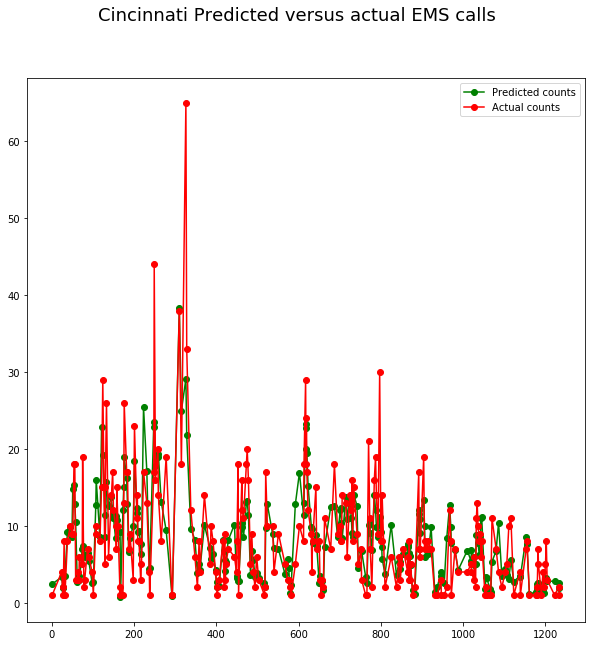

<Figure size 432x288 with 0 Axes>

In [51]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(10,10))
fig.suptitle('Cincinnati Predicted versus actual EMS calls', size=18)
predicted, = plt.plot(predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
plt.savefig('Cincy_EMS_poisson')

Text(0, 0.5, 'frequency')

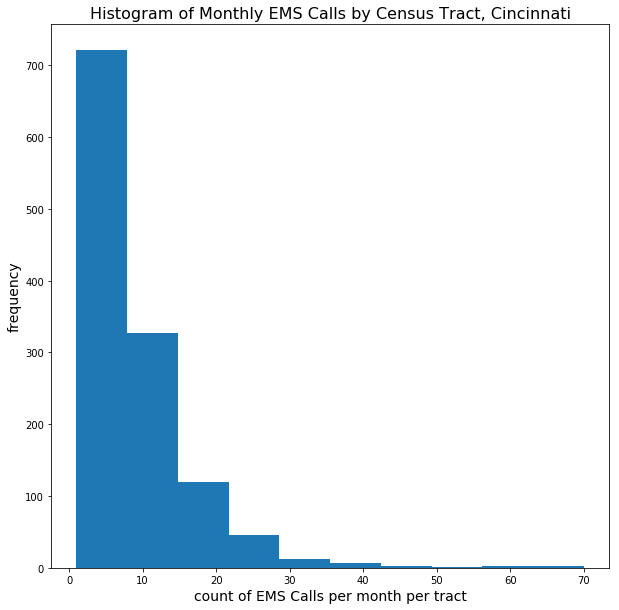

In [52]:
plt.figure(figsize=(10,10))
plt.hist(cin_gdf.ems_call)
plt.title('Histogram of Monthly EMS Calls by Census Tract, Cincinnati', size=16)
plt.xlabel('count of EMS Calls per month per tract', size=14)
plt.ylabel('frequency', size=14)

In [53]:
var = ['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi', 'SurgicalCentersCount2mi',
       'UrgentCareCount2mi', 'WomensClinicsCount2mi', 'PainManagementCount2mi','PhysicalTherapyCount2mi'
       'MentalFacilitiesCount2mi', 'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi', 
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi', 'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi',
       'PharmCount2mi', 'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'Med_HHD_Inc_ACS_13_17',
       'pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 'pct_Pop_18_24_ACS_13_17', 'pct_Pop_25_44_ACS_13_17', 'year_month',
       'ems_call']


### Logit

In [54]:
dfl = cin_gdf.filter(var)

In [55]:
dfl.head()

,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi,pct_College_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17,ems_call
0,3,1,7,6,0,1,1,9,9,2,0,0,13,1,16,68.86,53.27,11.99,50.83,1
1,3,1,7,6,0,1,1,9,9,2,0,0,13,1,16,68.86,53.27,11.99,50.83,1
2,3,1,7,6,0,1,1,9,9,2,0,0,13,1,16,68.86,53.27,11.99,50.83,2
3,3,1,7,6,0,1,1,9,9,2,0,0,13,1,16,68.86,53.27,11.99,50.83,2
4,3,1,7,6,0,1,1,9,9,2,0,0,13,1,16,68.86,53.27,11.99,50.83,6


In [56]:
dfl['ems_flag'] = 0 

In [57]:
for i in range(len(dfl)):
    if dfl['ems_call'][i] >= np.median(dfl['ems_call']):
        dfl.loc[i, 'ems_flag'] = 1

In [58]:
dfl.ems_flag.value_counts()

1    676
0    562
Name: ems_flag, dtype: int64

(array([562.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 676.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

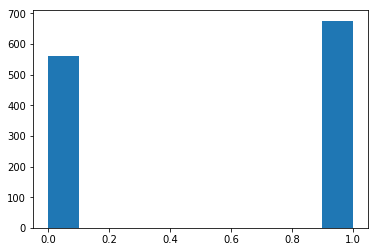

In [59]:
plt.hist(dfl.ems_flag)

In [60]:
np.median(dfl.ems_call)

6.0

(array([721., 327., 120.,  45.,  12.,   6.,   2.,   1.,   2.,   2.]),
 array([ 1. ,  7.9, 14.8, 21.7, 28.6, 35.5, 42.4, 49.3, 56.2, 63.1, 70. ]),
 <a list of 10 Patch objects>)

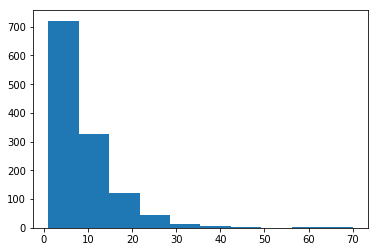

In [61]:
plt.hist(dfl.ems_call)

In [62]:
yl = dfl.ems_flag
Xl = dfl

In [63]:
Xl.drop('ems_flag', inplace=True, axis=1)

In [64]:
res = sm.Logit(yl, Xl).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.032903
         Iterations 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                 1238
Model:                          Logit   Df Residuals:                     1218
Method:                           MLE   Df Model:                           19
Date:                Tue, 10 Dec 2019   Pseudo R-squ.:                  0.9522
Time:                        22:12:56   Log-Likelihood:                -40.734
converged:                       True   LL-Null:                       -852.86
                                        LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
HospitalsGeneralCount2mi          2.3249      0.913      2.546      0.011       0.535       4.115
HospitalsPsychCount2mi           -6.2438      1.708     -3.656      0.000      -9.591      -2.897
SurgicalCentersCount2mi           0.2150      0.358      0.601      0.548      -0.486       0.916
UrgentCareCount2mi                0.1234      0.638      0.193      0.847      -1.127       1.374
WomensClinicsCount2mi            -2.5874      0.918     -2.817      0.005      -4.387      -0.787
PainManagementCount2mi            1.8574      1.380      1.346      0.178      -0.848       4.563
SubstanceAbuseCount2mi            1.3876      0.659      2.106      0.035       0.096       2.679
OtherMedicalFacilitesCount2mi     0.1900      0.137      1.384      0.166      -0.079       0.459
NursingAssistedLiveCount2mi      -0.4799      0.180     -2.662      0.008      -0.833      -0.127
HospiceCount2mi                  -0.4910      0.858     -0.572      0.567      -2.172       1.190
HospitalsChildCount2mi           -3.0575      1.067     -2.865      0.004      -5.149      -0.966
ChildFacilitiesCount2mi          -5.4184      1.561     -3.470      0.001      -8.479      -2.358
PharmCount2mi                     0.0002      0.153      0.001      0.999      -0.299       0.300
DrugDropCount2mi                 -2.8242      0.962     -2.936      0.003      -4.710      -0.939
NaloxoneDistribCount2mi          -0.2447      0.126     -1.943      0.052      -0.492       0.002
pct_College_ACS_13_17             0.0578      0.032      1.814      0.070      -0.005       0.120
pct_Males_ACS_13_17              -0.5670      0.114     -4.958      0.000      -0.791      -0.343
pct_Pop_18_24_ACS_13_17          -0.0145      0.040     -0.365      0.715      -0.093       0.063
pct_Pop_25_44_ACS_13_17          -0.1412      0.066     -2.155      0.031      -0.270      -0.013
ems_call                          6.2664      1.144      5.480      0.000       4.025       8.508
=================================================================================================

Possibly complete quasi-separation: A fraction 0.80 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [65]:
np.exp(res.params)

HospitalsGeneralCount2mi          10.226090
HospitalsPsychCount2mi             0.001942
SurgicalCentersCount2mi            1.239901
UrgentCareCount2mi                 1.131327
WomensClinicsCount2mi              0.075218
PainManagementCount2mi             6.407034
SubstanceAbuseCount2mi             4.005238
OtherMedicalFacilitesCount2mi      1.209233
NursingAssistedLiveCount2mi        0.618826
HospiceCount2mi                    0.612018
HospitalsChildCount2mi             0.047007
ChildFacilitiesCount2mi            0.004434
PharmCount2mi                      1.000193
DrugDropCount2mi                   0.059357
NaloxoneDistribCount2mi            0.782916
pct_College_ACS_13_17              1.059479
pct_Males_ACS_13_17                0.567213
pct_Pop_18_24_ACS_13_17            0.985596
pct_Pop_25_44_ACS_13_17            0.868301
ems_call                         526.571569
dtype: float64

In [66]:
df3 = cin_gdf.corr()

In [67]:
df4 = pd.DataFrame(df3['ems_call'])

In [68]:
df4[:21]

,ems_call
HospitalsGeneralCount2mi,0.137245
HospitalsPsychCount2mi,-0.029317
SurgicalCentersCount2mi,-0.062300
UrgentCareCount2mi,-0.118978
WomensClinicsCount2mi,0.172335
PainManagementCount2mi,0.257200
PhysicalTherapyCount2mi,-0.001588
MentalFacilitiesCount2mi,0.099455
SubstanceAbuseCount2mi,0.102888
OtherMedicalFacilitesCount2mi,0.210124


In [83]:
fac_cv = fac

In [86]:
fac_cv.drop(['CensusTract', 'geometry'], axis=1, inplace=True)

In [88]:
fac_cv.corr()

,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,HospitalsChildCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi
HospitalsGeneralCount2mi,1.000000,-0.050861,0.524646,0.239114,0.789320,0.479889,0.605575,0.875588,0.874814,0.869846,0.254970,0.192215,0.870782,0.113116,0.798115,0.583568,0.590719
HospitalsPsychCount2mi,-0.050861,1.000000,0.239559,0.320285,-0.340792,-0.109352,0.030451,-0.167272,-0.330623,-0.218243,0.086510,0.434665,-0.277636,-0.143933,-0.179874,-0.398126,-0.163773
SurgicalCentersCount2mi,0.524646,0.239559,1.000000,0.689255,0.196868,0.256229,0.612565,0.516155,0.408507,0.433569,0.401352,0.293874,0.445081,-0.072625,0.390919,0.223824,0.269658
UrgentCareCount2mi,0.239114,0.320285,0.689255,1.000000,-0.032461,0.406462,0.572403,0.166696,0.143654,0.197886,0.340390,0.220017,0.076753,0.008957,0.390052,0.013893,0.317820
WomensClinicsCount2mi,0.789320,-0.340792,0.196868,-0.032461,1.000000,0.471689,0.463273,0.745741,0.828167,0.870911,0.024375,-0.047493,0.718350,0.290520,0.734940,0.525049,0.491820
PainManagementCount2mi,0.479889,-0.109352,0.256229,0.406462,0.471689,1.000000,0.617746,0.509073,0.584625,0.631693,-0.034100,0.216013,0.337021,0.463310,0.655481,0.410886,0.306703
PhysicalTherapyCount2mi,0.605575,0.030451,0.612565,0.572403,0.463273,0.617746,1.000000,0.589413,0.660610,0.588826,0.415324,0.170470,0.587645,-0.035464,0.603277,0.335971,0.368173
MentalFacilitiesCount2mi,0.875588,-0.167272,0.516155,0.166696,0.745741,0.509073,0.589413,1.000000,0.902296,0.861444,0.189715,0.124904,0.860917,0.239964,0.751826,0.695414,0.444921
SubstanceAbuseCount2mi,0.874814,-0.330623,0.408507,0.143654,0.828167,0.584625,0.660610,0.902296,1.000000,0.907654,0.158804,0.037761,0.890829,0.238242,0.843760,0.699247,0.516618
OtherMedicalFacilitesCount2mi,0.869846,-0.218243,0.433569,0.197886,0.870911,0.631693,0.588826,0.861444,0.907654,1.000000,0.037869,0.163071,0.770799,0.397127,0.825525,0.570479,0.565631


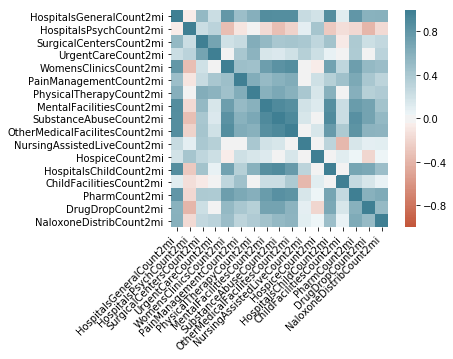

In [89]:
corr = fac.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [90]:
from sklearn.decomposition import PCA

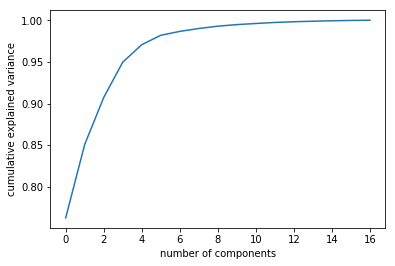

In [93]:
pca = PCA().fit(fac_cv.values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [96]:
pca_fac = PCA(n_components=2).fit(fac_cv.values)

In [100]:
fac_pca = pd.DataFrame(pca_fac.components_)

In [102]:
fac_pca = fac_pca.T

In [103]:
fac_pca

,0,1
0,0.166887,-0.028480
1,-0.008628,0.005119
2,0.083134,0.000616
3,0.038350,0.127180
4,0.071137,-0.050367
5,0.038401,-0.020975
6,0.054355,0.000802
7,0.132376,-0.100664
8,0.191209,-0.100714
9,0.705516,-0.479155


In [95]:
PCA?

In [84]:
fac_cv.columns

Index(['CensusTract', 'HospitalsGeneralCount2mi', 'HospitalsPsychCount2mi',
       'SurgicalCentersCount2mi', 'UrgentCareCount2mi',
       'WomensClinicsCount2mi', 'PainManagementCount2mi',
       'PhysicalTherapyCount2mi', 'MentalFacilitiesCount2mi',
       'SubstanceAbuseCount2mi', 'OtherMedicalFacilitesCount2mi',
       'NursingAssistedLiveCount2mi', 'HospiceCount2mi',
       'HospitalsChildCount2mi', 'ChildFacilitiesCount2mi', 'PharmCount2mi',
       'DrugDropCount2mi', 'NaloxoneDistribCount2mi', 'geometry'],
      dtype='object')

,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,SurgicalCentersCount2mi,UrgentCareCount2mi,WomensClinicsCount2mi,PainManagementCount2mi,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,...,Tract_26400,Tract_26500,Tract_26600,Tract_26700,Tract_26800,Tract_26900,Tract_27000,Tract_27100,Tract_27200,Tract_27400
0,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
1,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
2,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
3,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
4,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
5,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
6,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
7,3,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
8,2,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0
9,2,1,7,6,0,1,2,1,1,9,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ge_ACS_13_17	-0.178175
pct_Males_ACS_13_17	0.207492
pct_Pop_18_24_ACS_13_17	-0.070584
pct_Pop_25_44_ACS_13

In [108]:
cen_corr = cin_gdf.filter(['pct_College_ACS_13_17', 'pct_Males_ACS_13_17', 
                'pct_Pop_18_24_ACS_13_17','pct_Pop_25_44_ACS_13_17'])

In [109]:
cen_corr.corr()

,pct_College_ACS_13_17,pct_Males_ACS_13_17,pct_Pop_18_24_ACS_13_17,pct_Pop_25_44_ACS_13_17
pct_College_ACS_13_17,1.000000,0.219176,0.165182,0.524993
pct_Males_ACS_13_17,0.219176,1.000000,0.414221,0.156665
pct_Pop_18_24_ACS_13_17,0.165182,0.414221,1.000000,-0.319997
pct_Pop_25_44_ACS_13_17,0.524993,0.156665,-0.319997,1.000000


In [111]:
df4[:21]

,ems_call
HospitalsGeneralCount2mi,0.137245
HospitalsPsychCount2mi,-0.029317
SurgicalCentersCount2mi,-0.062300
UrgentCareCount2mi,-0.118978
WomensClinicsCount2mi,0.172335
PainManagementCount2mi,0.257200
PhysicalTherapyCount2mi,-0.001588
MentalFacilitiesCount2mi,0.099455
SubstanceAbuseCount2mi,0.102888
OtherMedicalFacilitesCount2mi,0.210124
